In [ ]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12,4)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pathlib

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
DATA_DIR = pathlib.Path("data")

# Loading data

In [ ]:
df = pd.read_csv("data/AEP_hourly.csv.zip", parse_dates=["Datetime"], index_col="Datetime")

In [ ]:
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


## Fix timestamps

In [ ]:
df.index.is_monotonic, df.index.is_unique

(False, False)

In [ ]:
df = df.sort_index()
df

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


### New index

In [ ]:
new_idx = pd.date_range("2004-10-01 01:00:00", "2018-08-03 00:00:00", freq="1H")

In [ ]:
df[~df.index.duplicated(keep='first')]

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


In [ ]:
dfi = df[~df.index.duplicated(keep='first')].reindex(new_idx)

In [ ]:
dfi.index.is_monotonic, dfi.index.is_unique, dfi.index.freq

(True, True, <Hour>)

### Missing values

In [ ]:
dfi.isnull().mean()

AEP_MW    0.000223
dtype: float64

In [ ]:
dfi.ffill(inplace=True)

# DalaModule

In [ ]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

In [ ]:
class ElectricityDataset(Dataset):
  """Dataset which samples the data from hourly electricity data."""

  def __init__(self, df, samples, hist_len=168, fct_len=24, col="AEP_MW"):
      self.hist_num = hist_len
      self.fct_num = fct_len
      self.hist_len = pd.Timedelta(hours=hist_len)
      self.fct_len = pd.Timedelta(hours=fct_len)
      self.offset = pd.Timedelta(hours=1)

      self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset
      self.raw_data = df

      assert samples <= self.raw_data[:self.max_ts].shape[0]
      self.samples = samples
      self.col = col
      self.sample()

  def sample(self):
      """Sample individual series as needed."""
      
      self.sample_idx = (self
                          .raw_data[:self.max_ts]
                          .index
                          .to_series()
                          .sample(self.samples, replace=False)
                          .index)

  def __len__(self):
      return self.samples

  def __getitem__(self, idx):
      start_ts = self.sample_idx[idx]
      
      hs, he = start_ts, start_ts + self.hist_len - self.offset
      fs, fe = he + self.offset, he + self.fct_len

      hist_data = self.raw_data[hs:].iloc[:self.hist_num]
      fct_data = self.raw_data[fs:].iloc[:self.fct_num]

      return (torch.Tensor(hist_data[self.col].values),
              torch.Tensor(fct_data[self.col].values))

In [ ]:
ds = ElectricityDataset(dfi, 10)

In [ ]:
start_ts = ds.sample_idx[4]

In [ ]:
dfi[start_ts:].head()

,AEP_MW
2015-10-13 07:00:00,13081.0
2015-10-13 08:00:00,13890.0
2015-10-13 09:00:00,13876.0
2015-10-13 10:00:00,13958.0
2015-10-13 11:00:00,14155.0


In [ ]:
dfi[start_ts+pd.Timedelta(days=7):].head()

,AEP_MW
2015-10-20 07:00:00,14746.0
2015-10-20 08:00:00,15645.0
2015-10-20 09:00:00,15418.0
2015-10-20 10:00:00,15076.0
2015-10-20 11:00:00,14802.0


In [ ]:
ds[4]

(tensor([13081., 13890., 13876., 13958., 14155., 14310., 14287., 14321., 14178.,
         14086., 13998., 13879., 13957., 14442., 14328., 13669., 12846., 11910.,
         11301., 10852., 10681., 10729., 10877., 11664., 13019., 13878., 13866.,
         13878., 13952., 13902., 13863., 13956., 13823., 13732., 13777., 13691.,
         13740., 14370., 14316., 13790., 12827., 12085., 11590., 11305., 11091.,
         11264., 11476., 12310., 13796., 14656., 14710., 14528., 14531., 14349.,
         14299., 14247., 14146., 14038., 13912., 13807., 13849., 14491., 14376.,
         13825., 13013., 12165., 11598., 11276., 11110., 11109., 11324., 12039.,
         13310., 14139., 14116., 14281., 14267., 14072., 13974., 13885., 13686.,
         13428., 13372., 13241., 13301., 13861., 13859., 13545., 12994., 12318.,
         11750., 11518., 11318., 11406., 11542., 11890., 12530., 13142., 13531.,
         13634., 13527., 13241., 13052., 12825., 12617., 12500., 12461., 12571.,
         12798., 13578., 135

In [ ]:
class ElectricityDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, df,
                 train_range=("2004", "2015"),
                 val_range=("2016","2017"),
                 test_range=("2018", None),
                 factor=0.5,
                 batch_size=64,
                 workers=3):

        super().__init__()
        self.raw_data = df
        self.train_range = train_range
        self.val_range = val_range
        self.test_range = test_range
        self.factor = factor
        self.batch_size = batch_size
        self.workers = workers

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data[slice(*self.train_range)]
            val_df = self.raw_data[slice(*self.val_range)]

            self.train_ds = ElectricityDataset(train_df,
                                               samples=int(self.factor * train_df.shape[0]))
            self.val_ds = ElectricityDataset(val_df,
                                             samples=int(self.factor * val_df.shape[0]))

        if stage == "test" or stage is None:
            test_df = self.raw_data[slice(*self.test_range)]
            self.test_ds = ElectricityDataset(test_df,
                                              samples=int(self.factor * test_df.shape[0]))

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

# Encoder network

In [ ]:
class ElectricityEncoder(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, num_layers=1, hidden_units=8):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units

        self.encoder = nn.LSTM(input_size=1,
                               hidden_size=self.hidden_units,
                               num_layers=self.num_layers,
                               batch_first=True)

    def forward(self, x):
        output, (henc, cenc) = self.encoder(x.view(x.shape[0], x.shape[1], 1))
        
        return output, henc, cenc

In [ ]:
encoder = ElectricityEncoder()

In [ ]:
hist_sample = torch.cat([ds[3][0].unsqueeze(0),
                         ds[5][0].unsqueeze(0)])

fct_sample = torch.cat([ds[3][1].unsqueeze(0),
                        ds[5][1].unsqueeze(0)])

output, hc, cc = encoder(hist_sample)

In [ ]:
hist_sample.shape

torch.Size([2, 168])

In [ ]:
hc.shape

torch.Size([1, 2, 8])

In [ ]:
output.shape

torch.Size([2, 168, 8])

In [ ]:
cc.shape

torch.Size([1, 2, 8])

# Decoder network

In [ ]:
class ElectricityDecoder(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, num_layers=1, hidden_units=8):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units

        self.decoder = nn.LSTM(input_size=1,
                               hidden_size=self.hidden_units,
                               num_layers=self.num_layers,
                               batch_first=True)
        self.linear = nn.Linear(self.hidden_units, 1)

    def forward(self, x, hidden):
        output, (hc, cc) = self.decoder(x.view(x.shape[0], x.shape[1], 1), hidden)
        output = self.linear(output.squeeze(1))
        return output, hc, cc

In [ ]:
decoder = ElectricityDecoder()

In [ ]:
a, b, c = decoder(hist_sample[:, [-1]], (hc, cc))

In [ ]:
decoder(a, (b, c))

(tensor([[-0.3515],
         [-0.3515]], grad_fn=<AddmmBackward>),
 tensor([[[-0.2045, -0.0726,  0.0394,  0.5904, -0.5509,  0.3191, -0.1803,
            0.0448],
          [-0.2045, -0.0726,  0.0394,  0.5904, -0.5509,  0.3191, -0.1803,
            0.0448]]], grad_fn=<StackBackward>),
 tensor([[[ -0.4452,  -0.1593,   0.0905,   1.1344, -68.7951,   0.6620,  -0.4683,
             0.0715],
          [ -0.4452,  -0.1593,   0.0905,   1.1344, -68.7951,   0.6620,  -0.4683,
             0.0715]]], grad_fn=<StackBackward>))

In [ ]:
a.shape

torch.Size([2, 1])

# Encoder-decoder model

In [ ]:
class ElectricityModel(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, num_layers=1, hidden_units=8, lr=1e-3):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.lr = lr

        self.encoder = ElectricityEncoder(hist_len, fct_len, num_layers, hidden_units)
        self.decoder = ElectricityDecoder(hist_len, fct_len, num_layers, hidden_units)

    def forward(self, x):
        forecasts = []
        enc, hh, cc = self.encoder(x)
        enc = x[:, [-1]]

        for i in range(self.fct_len):
            enc, hc, cc = self.decoder(enc, (hh, cc))
            forecasts.append(enc)
        forecasts = torch.cat(forecasts, dim=1)
        return forecasts

    def training_step(self, batch, batch_idx):
        x, y = batch
        fct = self(x)
        return F.mse_loss(fct, y)

    def validation_step(self, batch, batch_idx):

        x, y = batch
        logits = self(x)
        loss = F.mse_loss(logits, y)
        self.log('val_mse', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer

# Scaling

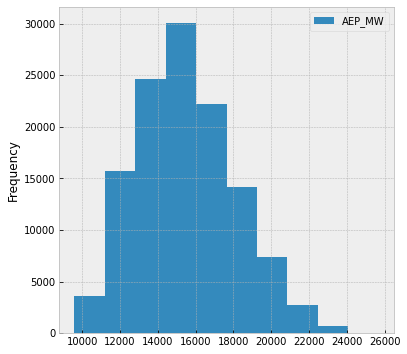

In [ ]:
plt.figure(figsize=(6,6))
dfi.plot(kind="hist", ax=plt.gca())

In [ ]:
LIMH, LIML =26e3, 9e3

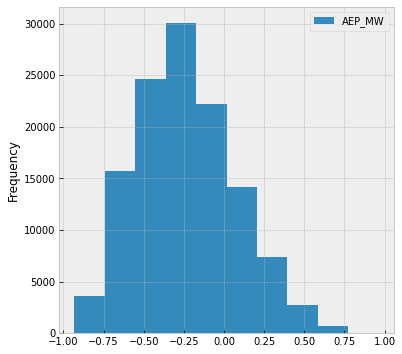

In [ ]:
plt.figure(figsize=(6,6))
((2 * dfi - LIML - LIMH) / (LIMH - LIML)).plot(kind="hist", ax=plt.gca())

In [ ]:
dfs = (2 * dfi - LIML - LIMH) / (LIMH - LIML)

ds = ElectricityDataModule(dfs, batch_size=128)
model = ElectricityModel(lr=1e-3, hidden_units=32)
trainer = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=1)
trainer.fit(model, ds)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | ElectricityEncoder | 4.5 K 
1 | decoder | ElectricityDecoder | 4.5 K 
-----------------------------------------------
9.0 K     Trainable params
0         Non-trainable params
9.0 K     Total params


1

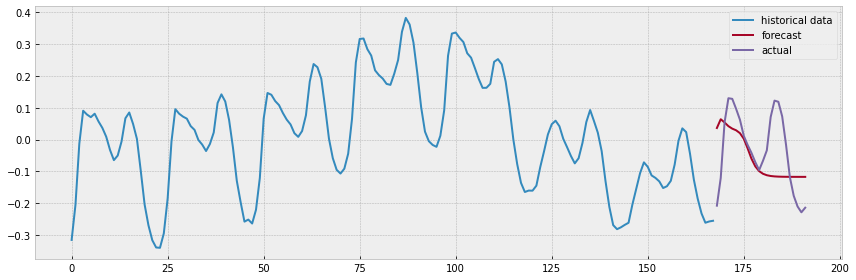

In [ ]:
plt.plot((( 2 * hist_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[0], label="historical data")
plt.plot(np.arange(168, 192, 1), model(hist_sample).detach().numpy()[0], label="forecast")
plt.plot(np.arange(168, 192, 1), (( 2 * fct_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[0], label="actual")

plt.legend(loc=0)
plt.tight_layout()